<a href="https://colab.research.google.com/github/drizedunn/ML-Quote-App/blob/main/mlquote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Occupation prediction

In [ ]:
# Importing the needed libraries

# !pip install shap
# !pip install colorama
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime
import plotly.express as px
import plotly.offline as po
import cufflinks as cl
plt.style.use('seaborn')
from colorama import Style, Fore, Back
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from joblib import dump
import shap
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Data Collection and loading

The data is a credit card application record data collected from https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction?select=application_record.csv

In [30]:
#reading the data
# data = pd.read_csv('/content/drive/MyDrive/Datasets/application_record.csv')
data = pd.read_csv('./dataset/application_record.csv')

In [5]:
#Displaying the first five rows of the data
data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [6]:
# Names of all the columns in the dataset
data.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

In [31]:
#Selecting only the columns that are relevant for the prediction of the variable "Occupation"
t_data = data[['ID', 'CODE_GENDER', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE']]

In [32]:
t_data.head()

,ID,CODE_GENDER,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,OCCUPATION_TYPE
0,5008804,M,427500.0,Working,Higher education,Civil marriage,NaN
1,5008805,M,427500.0,Working,Higher education,Civil marriage,NaN
2,5008806,M,112500.0,Working,Secondary / secondary special,Married,Security staff
3,5008808,F,270000.0,Commercial associate,Secondary / secondary special,Single / not married,Sales staff
4,5008809,F,270000.0,Commercial associate,Secondary / secondary special,Single / not married,Sales staff


In [33]:
t_data.columns

Index(['ID', 'CODE_GENDER', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE'],
      dtype='object')

In [34]:
#Renaming the columns
t_data.columns = ['id', 'gender', 'annual_income', 'income_type', 'education_type', 'marriage_status', 'interest']

In [35]:
t_data.columns

Index(['id', 'gender', 'annual_income', 'income_type', 'education_type',
       'marriage_status', 'interest'],
      dtype='object')

The column names has been changed

## Data Preparation

In [36]:
t_data.isnull().sum()

id                      0
gender                  0
annual_income           0
income_type             0
education_type          0
marriage_status         0
interest           134203
dtype: int64

The Interest column has a lot of has alot of missing values which must be filled. These values will be filled with the value "Education". This is because, in our present world, lots are interested in education.


In [37]:
#Replacing the missind values with Education
t_data['interest'] = t_data['interest'].fillna('Education')

In [38]:
t_data.isnull().sum()

id                 0
gender             0
annual_income      0
income_type        0
education_type     0
marriage_status    0
interest           0
dtype: int64

No more missing values

In [39]:
#Exploring the unique values of each of the columns exept the annual_income
coll = ['gender', 'income_type', 'education_type', 'marriage_status', 'interest']
for col in coll:
  print(f"The unique values in column '{col}' are: {t_data[col].unique()}\n\n")

The unique values in column 'gender' are: ['M' 'F']


The unique values in column 'income_type' are: ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']


The unique values in column 'education_type' are: ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']


The unique values in column 'marriage_status' are: ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']


The unique values in column 'interest' are: ['Education' 'Security staff' 'Sales staff' 'Accountants' 'Laborers'
 'Managers' 'Drivers' 'Core staff' 'High skill tech staff'
 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Low-skill Laborers' 'Medicine staff' 'Secretaries'
 'Waiters/barmen staff' 'HR staff' 'Realty agents' 'IT staff']




In [40]:
#Renaming the clases of the education_type columns

t_data['education_type'] = t_data['education_type'].replace('Secondary / secondary special', 'Higher Secondary')
t_data['education_type'] = t_data['education_type'].replace('Incomplete higher', 'Incomplete Secondary')

In [41]:
#Regrouping the clases of the marriage_status columns

t_data['marriage_status'] = t_data['marriage_status'].replace(['Civil marriage', 'Married'], 'Married')
t_data['marriage_status'] = t_data['marriage_status'].replace('Single / not married', 'Single')

In [42]:
#Regrouping the clases of the interest columns

t_data['interest'] = t_data['interest'].replace(['High skill tech staff', 'IT staff'], 'Technology')
t_data['interest'] = t_data['interest'].replace(['Security staff', 'Laborers', 'Drivers', 'Low-skill Laborers'], 'Safety')
t_data['interest'] = t_data['interest'].replace(['Sales staff', 'Managers', 'Accountants', 'Secretaries', 'HR staff', 'Core staff'], 'Business growth')
t_data['interest'] = t_data['interest'].replace(['Cleaning staff', 'Medicine staff', 'Cooking staff', 'Low-skill Laborers'], 'Health')
t_data['interest'] = t_data['interest'].replace(['Private service staff', 'Waiters/barmen staff', 'Realty agents'], 'Customer Satisfaction')

In [43]:
#Confirming the changes made to the columns
coll = ['gender', 'income_type', 'education_type', 'marriage_status', 'interest']
for col in coll:
  print(f"The unique values in column '{col}' are: {t_data[col].unique()}\n\n")

The unique values in column 'gender' are: ['M' 'F']


The unique values in column 'income_type' are: ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']


The unique values in column 'education_type' are: ['Higher education' 'Higher Secondary' 'Incomplete Secondary'
 'Lower secondary' 'Academic degree']


The unique values in column 'marriage_status' are: ['Married' 'Single' 'Separated' 'Widow']


The unique values in column 'interest' are: ['Education' 'Safety' 'Business growth' 'Technology' 'Health'
 'Customer Satisfaction']




## Exploratory Data Analysis

In [44]:
#Dispaly basic information about the dataset
t_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               438557 non-null  int64  
 1   gender           438557 non-null  object 
 2   annual_income    438557 non-null  float64
 3   income_type      438557 non-null  object 
 4   education_type   438557 non-null  object 
 5   marriage_status  438557 non-null  object 
 6   interest         438557 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 23.4+ MB


In [45]:
t_data.shape

(438557, 7)

The dataset has **438557** observations(rows) and **7** features(columns)

In [46]:
t_data.columns

Index(['id', 'gender', 'annual_income', 'income_type', 'education_type',
       'marriage_status', 'interest'],
      dtype='object')

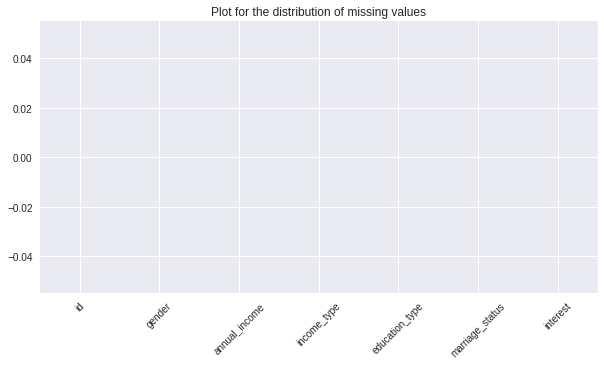

In [47]:
t_data.isnull().sum().plot(kind = 'bar', figsize = (10, 5))
plt.title("Plot for the distribution of missing values")
plt.xticks(rotation = 45)
plt.show()

From the graph above, there is no missing values



In [48]:
obs = t_data['id'].nunique()
print(f"The observation was recoeded for {obs} people")

The observation was recoeded for 438510 people


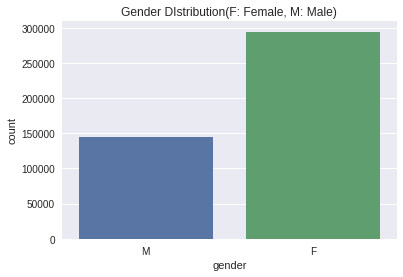

In [23]:
#Plotting the gender
sns.countplot(t_data['gender']).set_title("Gender DIstribution(F: Female, M: Male)")
plt.show()

**Female** has the highest frequency 